In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

In [35]:
df = pd.read_csv("measures_v2.csv")

In [36]:
col_list = df.columns.tolist()
profile_id = ['profile_id']
target_list = ['pm', 'torque', 'stator_yoke', 'stator_tooth', 'stator_winding']
feature_list = [col for col in col_list if col not in target_list and col not in profile_id]

In [37]:
df['profile_id'] = df.profile_id.astype('category')
df.profile_id.unique()

[17, 5, 12, 32, 21, ..., 60, 46, 58, 78, 71]
Length: 69
Categories (69, int64): [2, 3, 4, 5, ..., 78, 79, 80, 81]

In [38]:
def build_sequences(features_df, target_df, sequence_length = 10):
    """Builds sequences from data and converts them into pytorch tensors
        sequence_length - represents the number of samples to be considered in a sequence
    """
    data_ = []
    target_ = []
    
    for i in range(int(features_df.shape[0]/sequence_length)):
        
        data = torch.from_numpy(features_df.iloc[i:i+sequence_length].values.T)
        target = torch.from_numpy(target_df.iloc[i+sequence_length+1].values.T)
        
        data_.append(data)
        target_.append(target)
        
    data = torch.stack(data_)
    target = torch.stack(target_)
    
    
    return data, target

In [39]:
prof_ids = list(df.profile_id.unique())
print(prof_ids)

[17, 5, 12, 32, 21, 2, 4, 7, 19, 3, 9, 23, 27, 26, 11, 6, 10, 13, 31, 18, 30, 29, 8, 24, 20, 15, 14, 16, 36, 74, 75, 41, 68, 50, 53, 49, 81, 80, 59, 54, 57, 70, 51, 55, 45, 69, 61, 76, 56, 64, 72, 73, 62, 65, 63, 43, 47, 66, 42, 48, 67, 44, 79, 52, 60, 46, 58, 78, 71]


In [40]:


prof_id = 24
print('Selected profile -',prof_id)

Selected profile - 24


In [41]:
curr_df = df[df['profile_id'] == prof_id]

curr_df = curr_df.drop('profile_id', axis = 1)
columns = curr_df.columns.tolist()

In [42]:
scaler = MinMaxScaler()

curr_df = pd.DataFrame(scaler.fit_transform(curr_df), columns= columns)
curr_df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque
0,5.803257e-05,0.792777,0.000142,0.999898,0.002228,8.111477e-07,0.999984,0.000058,0.005236,0.002534,0.150943,0.196385
1,8.303860e-07,0.785832,0.000120,0.998914,0.002485,2.935503e-07,0.999982,0.000063,0.005181,0.002981,0.150188,0.196279
2,7.577078e-05,0.778928,0.000139,0.999921,0.002670,0.000000e+00,0.999981,0.000056,0.005098,0.002923,0.150396,0.196427
3,1.513673e-04,0.769654,0.000137,0.999938,0.002397,5.082567e-07,1.000000,0.000008,0.005059,0.002562,0.150444,0.196343
4,6.470874e-05,0.761601,0.000143,0.999125,0.001646,5.546645e-07,0.999988,0.000048,0.005069,0.002059,0.150007,0.196359


In [43]:
sequence_length = 7

features = curr_df[feature_list]
target = curr_df[target_list][['pm']]

data, target = build_sequences(features, target, sequence_length=sequence_length)

In [44]:
data.shape

torch.Size([2145, 7, 7])

In [45]:
# Test size the percentage of data to be used for testing
test_size = 0.05

indices = torch.randperm(data.shape[0])

train_indices = indices[:int(indices.shape[0] * (1-test_size))]
test_indices = indices[int(indices.shape[0] * (1-test_size)):]

X_train, y_train = data[train_indices], target[train_indices]
X_test, y_test = data[test_indices], target[test_indices]

In [46]:
class PMSMDataset(torch.utils.data.dataset.Dataset):
    """Dataset with Rotor Temperature as Target"""
    def __init__(self, data, target):
        
        self.data = data
        self.target = target
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx].float(), self.target[idx].float()

In [47]:
batch_size = 10

pm_train_dataset = PMSMDataset(X_train, y_train)
pm_train_loader = torch.utils.data.dataloader.DataLoader(pm_train_dataset, batch_size= batch_size)

pm_test_dataset = PMSMDataset(X_test, y_test)
pm_test_loader = torch.utils.data.dataloader.DataLoader(pm_test_dataset, batch_size= 1)

In [48]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1D-CNN

In [53]:
class Network(nn.Module):
    def __init__(self, sequence_length, n_features):
        super(Network, self).__init__()
        
        self.sequence_length = sequence_length
        self.n_features = n_features
        
        self.features = nn.Sequential(
                        nn.Conv1d(n_features, 16, kernel_size=3),
                        nn.ReLU(),
                        nn.Conv1d(16,32, kernel_size=1))
        
        self.lin_in_size = self.get_lin_in_size()
        
        self.predictior = nn.Sequential(
                        nn.Linear(self.lin_in_size,30),
                        nn.ReLU(),
                        nn.Linear(30, 1))
        
    def forward(self, x):
        
        x = self.features(x)
        x = x.view(-1, self.lin_in_size)
        x = self.predictior(x)
        return x
    
    def get_lin_in_size(self):
        rand_in = torch.rand(10, self.n_features, self.sequence_length)
        rand_out = self.features(rand_in)
        return rand_out.shape[-1] * rand_out.shape[-2]
        

In [54]:
n_features = X_train.shape[-2]
net = Network(sequence_length, n_features)
net = net.to(device)

lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [55]:
def test(net, test_loader, criterion):
    
    net.eval()
    losses = []
    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device) 
        out = net(data)
        loss = criterion(out, target)
        losses.append(loss.item())  
    
    net.train()
    return np.mean(losses)

def train(n_epochs, net, train_loader, test_loader, optimizer, criterion, interval = 10):
    net.train()
    training_losses = []
    test_losses = []
    
    for epoch in range(1,n_epochs+1):
        running_loss = 0.0
        batch_losses = []
        
        for i, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device) 
            
            optimizer.zero_grad()
            out = net(data)
            loss = criterion(out, target)
            batch_losses.append(loss.item())
            
            loss.backward()
            optimizer.step()
        
        training_losses.append(np.mean(batch_losses))
        
        test_losses.append(test(net, test_loader, criterion))
        
        if epoch%interval==1:
            print("Epoch {}, Training loss {:.6f}, Testing loss {:.6f}".format(epoch, training_losses[-1], test_losses[-1]))
    return training_losses, test_losses

In [56]:
training_losses, test_losses = train(50, net, pm_train_loader, pm_test_loader, optimizer, criterion)

Epoch 1, Training loss 0.016650, Testing loss 0.002371
Epoch 11, Training loss 0.000081, Testing loss 0.000049
Epoch 21, Training loss 0.000074, Testing loss 0.000037
Epoch 31, Training loss 0.000063, Testing loss 0.000032
Epoch 41, Training loss 0.000057, Testing loss 0.000031


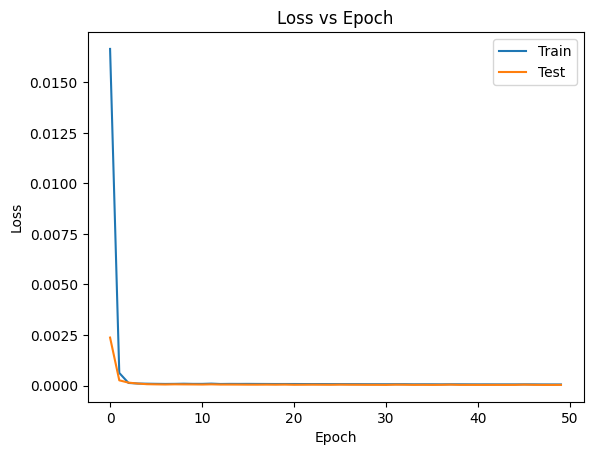

In [57]:
plt.plot(training_losses, label='Train')
plt.plot(test_losses, label ='Test')
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
def get_predictions(net, loader):
    targets = []
    outputs = []
    net.eval()
    device = next(net.parameters()).device  # Get the device of the model parameters
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)  # Move data and target to the same device
            out = net(data)
            targets.append(target.item())
            outputs.append(out.mean().item())  # Assuming you want the mean of the output tensor
    return targets, outputs


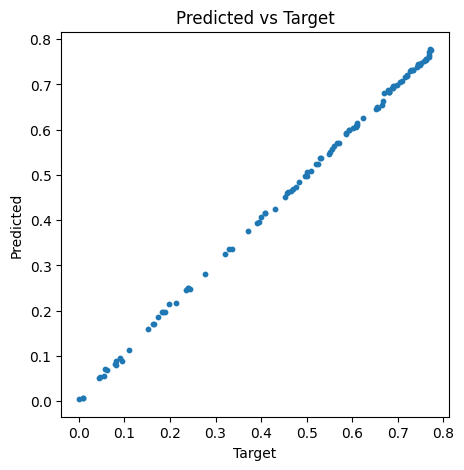

In [58]:
targets, outputs = get_predictions(model, pm_test_loader)

plt.figure(figsize=(5,5))
plt.scatter(targets, outputs, s=10)
plt.xlabel("Target")
plt.ylabel("Predicted")
plt.title("Predicted vs Target")
plt.show()

In [59]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score, median_absolute_error

print("R2 Score - ", r2_score(targets, outputs))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(targets, outputs)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(targets, outputs)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(targets, outputs, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((np.array(targets) - np.array(outputs)) / np.array(targets))) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

# Calculate Explained Variance Score
explained_variance = explained_variance_score(targets, outputs)
print("Explained Variance Score:", explained_variance)

# Calculate Median Absolute Error
median_ae = median_absolute_error(targets, outputs)
print("Median Absolute Error:", median_ae)


R2 Score -  0.999437790831636
Mean Absolute Error (MAE): 0.004612315959228134
Mean Squared Error (MSE): 3.1833016032425806e-05
Root Mean Squared Error (RMSE): 0.005642075507508368
Mean Absolute Percentage Error (MAPE): inf
Explained Variance Score: 0.9995334779399314
Median Absolute Error: 0.004155337810516357


/home/balawima/miniconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/tmp/ipykernel_70976/1569188179.py:18: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((np.array(targets) - np.array(outputs)) / np.array(targets))) * 100


# LSTM

In [60]:
import torch
import torch.nn as nn


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Ensure the input_size matches the number of features
input_size = len(feature_list)  # Number of features
hidden_size = 64  # Number of features in the hidden state
num_layers = 2  # Number of stacked LSTM layers
output_size = len(target_list)  

# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/home/balawima/miniconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/balawima/miniconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([7, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/balawima/miniconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 5])). This will likely lead to incorrect results due

Epoch [1/150], Train Loss: 0.06040424, Test Loss: 0.05372036
Epoch [2/150], Train Loss: 0.04458382, Test Loss: 0.05178122
Epoch [3/150], Train Loss: 0.03440657, Test Loss: 0.03381038
Epoch [4/150], Train Loss: 0.02459336, Test Loss: 0.01747635
Epoch [5/150], Train Loss: 0.01018217, Test Loss: 0.00198157
Epoch [6/150], Train Loss: 0.00185600, Test Loss: 0.00159892
Epoch [7/150], Train Loss: 0.00118209, Test Loss: 0.00076709
Epoch [8/150], Train Loss: 0.00091955, Test Loss: 0.00060696
Epoch [9/150], Train Loss: 0.00072826, Test Loss: 0.00053065
Epoch [10/150], Train Loss: 0.00058504, Test Loss: 0.00046747
Epoch [11/150], Train Loss: 0.00047892, Test Loss: 0.00058356
Epoch [12/150], Train Loss: 0.00044691, Test Loss: 0.00053175
Epoch [13/150], Train Loss: 0.00043376, Test Loss: 0.00042067
Epoch [14/150], Train Loss: 0.00041701, Test Loss: 0.00037880
Epoch [15/150], Train Loss: 0.00039574, Test Loss: 0.00035863
Epoch [16/150], Train Loss: 0.00037727, Test Loss: 0.00034344
Epoch [17/150], T

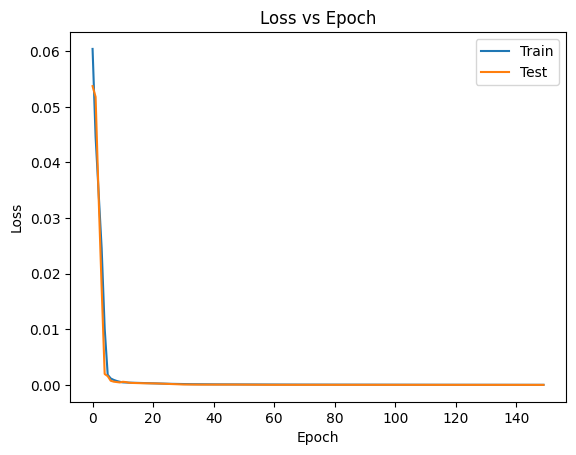

In [61]:
# Training the model
num_epochs = 150
training_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (data, target) in enumerate(pm_train_loader):
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(pm_train_loader)
    training_losses.append(train_loss)
    
    # Testing loop
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in pm_test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()
    
    test_loss /= len(pm_test_loader)
    test_losses.append(test_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f}')

# Plotting the losses
import matplotlib.pyplot as plt

plt.plot(training_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


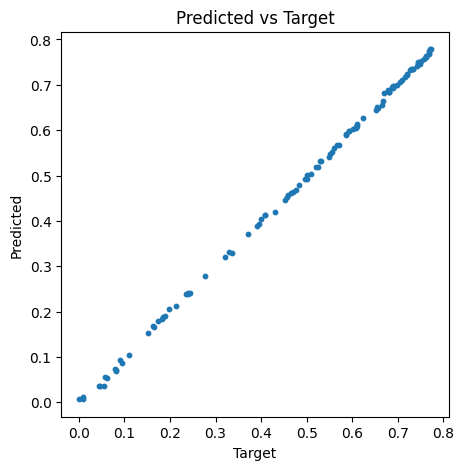

In [62]:
targets, outputs = get_predictions(model, pm_test_loader)

plt.figure(figsize=(5,5))
plt.scatter(targets, outputs, s=10)
plt.xlabel("Target")
plt.ylabel("Predicted")
plt.title("Predicted vs Target")
plt.show()

In [63]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score, median_absolute_error

print("R2 Score - ", r2_score(targets, outputs))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(targets, outputs)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(targets, outputs)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(targets, outputs, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((np.array(targets) - np.array(outputs)) / np.array(targets))) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

# Calculate Explained Variance Score
explained_variance = explained_variance_score(targets, outputs)
print("Explained Variance Score:", explained_variance)

# Calculate Median Absolute Error
median_ae = median_absolute_error(targets, outputs)
print("Median Absolute Error:", median_ae)


R2 Score -  0.9995118986436292
Mean Absolute Error (MAE): 0.0041205162113463435
Mean Squared Error (MSE): 2.763693510728877e-05
Root Mean Squared Error (RMSE): 0.005257084278123071
Mean Absolute Percentage Error (MAPE): inf
Explained Variance Score: 0.9995153077170469
Median Absolute Error: 0.0037577077746391296


/home/balawima/miniconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/tmp/ipykernel_70976/1569188179.py:18: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((np.array(targets) - np.array(outputs)) / np.array(targets))) * 100


# Bidirection LSTM

In [64]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 for bidirectional

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # Multiply by 2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Ensure the input_size matches the number of features
input_size = len(feature_list)  # Number of features
hidden_size = 64  # Number of features in the hidden state
num_layers = 2  # Number of stacked LSTM layers
output_size = len(target_list)  # Number of output features (e.g., 'pm')

model_Bidirictional = BiLSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_Bidirictional.parameters(), lr=0.001)  



In [65]:
print(len(feature_list))

7


/home/balawima/miniconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/balawima/miniconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([7, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/balawima/miniconda3/envs/torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 5])). This will likely lead to incorrect results due

Epoch [1/150], Train Loss: 0.05800690, Test Loss: 0.04778104
Epoch [2/150], Train Loss: 0.02940043, Test Loss: 0.01639336
Epoch [3/150], Train Loss: 0.01770391, Test Loss: 0.01482959
Epoch [4/150], Train Loss: 0.01700772, Test Loss: 0.01325952
Epoch [5/150], Train Loss: 0.01041788, Test Loss: 0.00192711
Epoch [6/150], Train Loss: 0.00218938, Test Loss: 0.00155056
Epoch [7/150], Train Loss: 0.00126600, Test Loss: 0.00055496
Epoch [8/150], Train Loss: 0.00073478, Test Loss: 0.00049774
Epoch [9/150], Train Loss: 0.00050257, Test Loss: 0.00053575
Epoch [10/150], Train Loss: 0.00037677, Test Loss: 0.00042520
Epoch [11/150], Train Loss: 0.00028588, Test Loss: 0.00024239
Epoch [12/150], Train Loss: 0.00023367, Test Loss: 0.00016660
Epoch [13/150], Train Loss: 0.00022745, Test Loss: 0.00012805
Epoch [14/150], Train Loss: 0.00021905, Test Loss: 0.00010790
Epoch [15/150], Train Loss: 0.00020844, Test Loss: 0.00009300
Epoch [16/150], Train Loss: 0.00019959, Test Loss: 0.00008169
Epoch [17/150], T

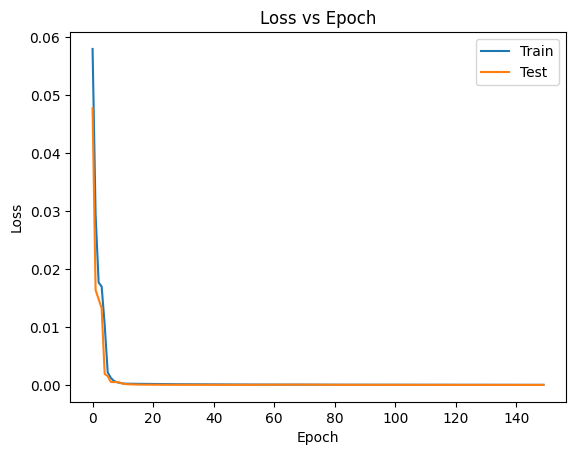

In [66]:
# Training the model
num_epochs = 150
training_losses = []
test_losses = []

for epoch in range(num_epochs):
    model_Bidirictional.train()
    train_loss = 0
    for i, (data, target) in enumerate(pm_train_loader):
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        outputs = model_Bidirictional(data)
        loss = criterion(outputs, target)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(pm_train_loader)
    training_losses.append(train_loss)
    
    # Testing loop
    model_Bidirictional.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in pm_test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model_Bidirictional(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()
    
    test_loss /= len(pm_test_loader)
    test_losses.append(test_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f}')

# Plotting the losses
import matplotlib.pyplot as plt

plt.plot(training_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


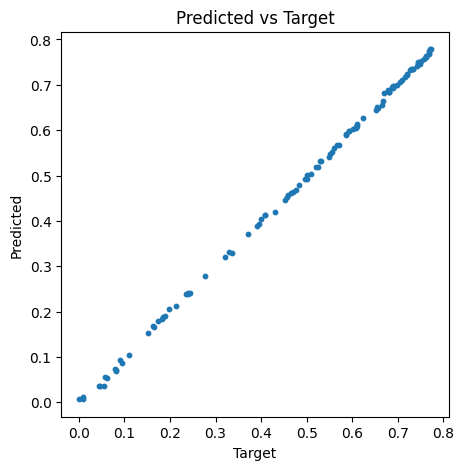

In [67]:
targets, outputs = get_predictions(model, pm_test_loader)

plt.figure(figsize=(5,5))
plt.scatter(targets, outputs, s=10)
plt.xlabel("Target")
plt.ylabel("Predicted")
plt.title("Predicted vs Target")
plt.show()

In [68]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score, median_absolute_error

print("R2 Score - ", r2_score(targets, outputs))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(targets, outputs)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(targets, outputs)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(targets, outputs, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((np.array(targets) - np.array(outputs)) / np.array(targets))) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

# Calculate Explained Variance Score
explained_variance = explained_variance_score(targets, outputs)
print("Explained Variance Score:", explained_variance)

# Calculate Median Absolute Error
median_ae = median_absolute_error(targets, outputs)
print("Median Absolute Error:", median_ae)


R2 Score -  0.9995118986436292
Mean Absolute Error (MAE): 0.0041205162113463435
Mean Squared Error (MSE): 2.763693510728877e-05
Root Mean Squared Error (RMSE): 0.005257084278123071
Mean Absolute Percentage Error (MAPE): inf
Explained Variance Score: 0.9995153077170469
Median Absolute Error: 0.0037577077746391296


/home/balawima/miniconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/tmp/ipykernel_70976/1569188179.py:18: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((np.array(targets) - np.array(outputs)) / np.array(targets))) * 100


In [294]:
# Save the model
torch.save(model.state_dict(), 'Bidirection_LSTM_99.9.pth')


/tmp/ipykernel_70976/676490581.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _1D_CNN = torch.load('1D-CNN_model.pth')


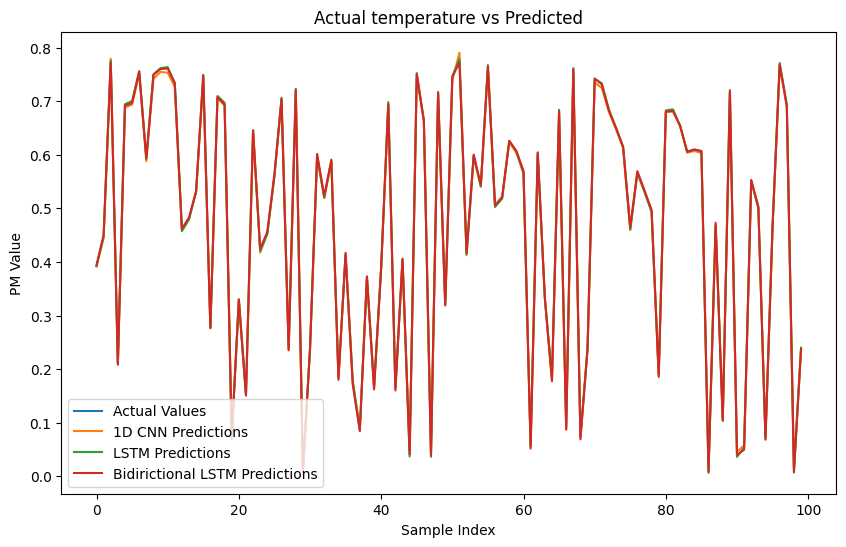

In [73]:
# load pre-trained 1D-CNN model for comparsion porpuse
_1D_CNN = torch.load('1D-CNN_model.pth')

# Get predictions and actual values for both models
actuals, predictions_bilstm = get_predictions(model_Bidirictional, pm_test_loader)
_, predictions_LSTM = get_predictions(model, pm_test_loader)
_, predictions_1D_CNN = get_predictions(net, pm_test_loader)

# Plotting the first 100 actual vs predicted values for both models
plt.figure(figsize=(10, 6))
plt.plot(actuals[1000:1100], label='Actual Values')
plt.plot(predictions_1D_CNN[:100], label='1D CNN Predictions')  
plt.plot(predictions_LSTM[:100], label='LSTM Predictions')
plt.plot(predictions_bilstm[:100], label='Bidirictional LSTM Predictions')

plt.xlabel('Sample Index')
plt.ylabel('PM Value')
plt.title('Actual temperature vs Predicted')
plt.legend()
plt.show()